In [179]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [180]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'COKE', 'VZ', 'F']
tickers.sort()

start = '2016-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Return'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
/tmp/ipykernel_3814690/1719358244.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return
4,2016-01-05,AAPL,23.288242,25.677500,26.462500,25.602501,26.437500,223164000,-0.025060
5,2016-01-05,COKE,166.498123,176.740005,179.410004,174.300003,177.020004,32600,0.009654
6,2016-01-05,F,8.630340,13.720000,14.000000,13.510000,13.970000,50267500,-0.017895
7,2016-01-05,VZ,29.956108,46.500000,46.549999,45.630001,46.200001,15632800,0.013734
8,2016-01-06,AAPL,22.832504,25.174999,25.592501,24.967501,25.139999,273829600,-0.019569
...,...,...,...,...,...,...,...,...,...
8695,2024-08-22,VZ,40.869999,40.869999,41.160000,40.610001,41.099998,13527300,-0.004385
8696,2024-08-23,AAPL,225.850006,225.850006,228.220001,224.339996,225.658997,19760035,0.005879
8697,2024-08-23,COKE,1353.500000,1353.500000,1374.250000,1351.000000,1374.250000,21173,-0.001836
8698,2024-08-23,F,11.190000,11.190000,11.239900,10.940000,10.980000,32050554,0.024725


In [181]:
benchmark = 'IWV'

# YF download
bmk = yf.download(benchmark, start=start)

# Reformat Dataframe
bmk = bmk.reset_index()

# Add daily return column
bmk['Return'] = bmk['Adj Close'].pct_change()

bmk = bmk.dropna()

bmk = bmk[['Date', 'Return']]

bmk_return = bmk['Return'].mean()

bmk

[*********************100%%**********************]  1 of 1 completed


,Date,Return
1,2016-01-05,0.002450
2,2016-01-06,-0.013483
3,2016-01-07,-0.023917
4,2016-01-08,-0.011464
5,2016-01-11,-0.000796
...,...,...
2170,2024-08-19,0.010247
2171,2024-08-20,-0.002512
2172,2024-08-21,0.003715
2173,2024-08-22,-0.008657


In [182]:
# Merge
merge = pd.merge(df, bmk, on='Date', how='left', suffixes=('_I', '_B'))

merge['Ri-Rb'] = merge['Return_I'] - merge['Return_B']

merge

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return_I,Return_B,Ri-Rb
0,2016-01-05,AAPL,23.288242,25.677500,26.462500,25.602501,26.437500,223164000,-0.025060,0.002450,-0.027509
1,2016-01-05,COKE,166.498123,176.740005,179.410004,174.300003,177.020004,32600,0.009654,0.002450,0.007204
2,2016-01-05,F,8.630340,13.720000,14.000000,13.510000,13.970000,50267500,-0.017895,0.002450,-0.020345
3,2016-01-05,VZ,29.956108,46.500000,46.549999,45.630001,46.200001,15632800,0.013734,0.002450,0.011284
4,2016-01-06,AAPL,22.832504,25.174999,25.592501,24.967501,25.139999,273829600,-0.019569,-0.013483,-0.006087
...,...,...,...,...,...,...,...,...,...,...,...
8691,2024-08-22,VZ,40.869999,40.869999,41.160000,40.610001,41.099998,13527300,-0.004385,-0.008657,0.004272
8692,2024-08-23,AAPL,225.850006,225.850006,228.220001,224.339996,225.658997,19760035,0.005879,0.009966,-0.004087
8693,2024-08-23,COKE,1353.500000,1353.500000,1374.250000,1351.000000,1374.250000,21173,-0.001836,0.009966,-0.011803
8694,2024-08-23,F,11.190000,11.190000,11.239900,10.940000,10.980000,32050554,0.024725,0.009966,0.014759


In [183]:
# Create assets dataframe

assets = merge.groupby('Ticker')['Return_I'].mean().rename("Expected Return").to_frame().reset_index()

assets['Volatility'] = merge.groupby('Ticker')['Return_I'].std().to_list()

assets['Sharpe Ratio'] = assets['Expected Return'] / assets['Volatility']

assets['Expected Excess Return'] = merge.groupby("Ticker")['Ri-Rb'].mean().to_list()

assets['Tracking Error'] = merge.groupby('Ticker')['Ri-Rb'].std().to_list()

assets['Information Ratio'] = assets['Expected Excess Return'] / assets['Tracking Error']

assets

,Ticker,Expected Return,Volatility,Sharpe Ratio,Expected Excess Return,Tracking Error,Information Ratio
0,AAPL,0.001201,0.018258,0.065754,0.000613,0.012297,0.049885
1,COKE,0.001256,0.023873,0.052619,0.000669,0.022341,0.029950
2,F,0.000388,0.023544,0.016491,-0.000199,0.019069,-0.010426
3,VZ,0.000228,0.012390,0.018436,-0.000359,0.013218,-0.027135


In [184]:
# Returns dataframe
return_matrix = merge[['Date','Ticker','Return_I']].pivot(index='Date', columns='Ticker', values='Return_I').dropna()

return_matrix

Ticker,AAPL,COKE,F,VZ
Date,,,,
2016-01-05,-0.025060,0.009654,-0.017895,0.013734
2016-01-06,-0.019569,0.018162,-0.044461,-0.009035
2016-01-07,-0.042205,-0.014003,-0.031274,-0.005492
2016-01-08,0.005288,0.002649,-0.012598,-0.009719
2016-01-11,0.016192,-0.029961,0.018341,0.005799
...,...,...,...,...
2024-08-19,-0.000708,0.010404,0.019981,0.003201
2024-08-20,0.002745,-0.004827,-0.003731,0.002700
2024-08-21,-0.000486,0.042052,0.015918,0.004896


In [185]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[3.33349243e-04, 1.07954320e-04, 1.46751851e-04, 5.03290067e-05],
       [1.07954320e-04, 5.69937966e-04, 1.38363255e-04, 6.35405239e-05],
       [1.46751851e-04, 1.38363255e-04, 5.54333340e-04, 6.79099653e-05],
       [5.03290067e-05, 6.35405239e-05, 6.79099653e-05, 1.53502149e-04]])

In [186]:
# Expected Returns Vector
expected_returns = assets['Expected Return'].values

expected_returns

array([0.00120053, 0.00125619, 0.00038827, 0.00022841])

In [187]:
# Portfolio metric functions
def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns)

def portfolio_excess_return(weights, expected_returns):
    return portfolio_return(weights, expected_returns) - bmk_return

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights,cov_matrix),weights.T))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    port_std = portfolio_volatility(weights, cov_matrix)
    return -port_er / port_std

def negative_information_ratio(weights, expected_returns, cov_matrix):
    port_xs_er = portfolio_excess_return(weights, expected_returns)
    port_te = portfolio_volatility(weights, cov_matrix)
    return - port_xs_er / port_te

In [188]:
# Display Weights Function
def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [189]:
# Baseline results

# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

# Baseline Results
port_xs_return = portfolio_excess_return(initial_weights, expected_returns)
port_te = portfolio_volatility(initial_weights,cov_matrix)
port_ir = port_xs_return / port_te

#Display
display_weights(tickers, initial_weights)
print(f"Portfolio Excess Return: {round(port_xs_return,2)} %")
print(f"Portfolio Tracking Error: {round(port_te,2)} %")
print(f"Portfolio Information Ratio: {round(port_ir,2)}")

,Ticker,Weight
0,AAPL,0.1
1,COKE,0.1
2,F,0.1
3,VZ,-0.3


Portfolio Excess Return: -0.0 %
Portfolio Tracking Error: 0.01 %
Portfolio Information Ratio: -0.07


In [190]:
# Optimization

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1

# Result
result = minimize(negative_information_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP', constraints=constraints)

optimal_weights = result.x

optimal_weights

array([ 2418.26502236,  2228.25992754, -1810.04064365, -2836.48430625])

In [191]:
# Optimal Results
opt_port_xs_return = portfolio_excess_return(optimal_weights, expected_returns)
opt_port_te = portfolio_volatility(optimal_weights,cov_matrix)
opt_port_ir = opt_port_xs_return / opt_port_te

# Display
display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Excess Return: {round(opt_port_xs_return,2)} %")
print(f"Optimized Portfolio Tracking Error: {round(opt_port_te,2)} %")
print(f"Optimized Portfolio Information Ratio: {round(opt_port_ir,2)}")

,Ticker,Weight
0,AAPL,2418.27
1,COKE,2228.26
2,F,-1810.04
3,VZ,-2836.48


Optimized Portfolio Excess Return: 4.35 %
Optimized Portfolio Tracking Error: 76.14 %
Optimized Portfolio Information Ratio: 0.06


In [192]:
# Efficient Frontier Chart

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)})

# Mean Variance Efficient function
def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_excess_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x)})
    result = minimize(portfolio_volatility, n*[1./n,], args=args[1],
                      method='SLSQP', constraints=constraints)
    return result.x

In [193]:
# Pro
n_points = 100
target_returns = np.linspace(0,2*opt_port_xs_return, n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

xs_returns = [portfolio_excess_return(w, expected_returns) for w in mve_portfolios]
tracking_errors = [portfolio_volatility(w, cov_matrix) for w in mve_portfolios]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]

for index in range(len(tickers)):
    portfolios[tickers[index]] = np.array([row[index] for row in mve_portfolios])
    portfolios[tickers[index]] = round(portfolios[tickers[index]],2)
    
portfolios['Expected Excess Return'] = xs_returns
portfolios['Tracking Error'] = tracking_errors
portfolios['Information Ratio'] = portfolios['Expected Excess Return'] / portfolios['Tracking Error']

portfolios

,Name,AAPL,COKE,F,VZ,Expected Excess Return,Tracking Error,Information Ratio
0,Portfolio 1,0.40,0.22,-0.15,-0.47,9.671571e-14,0.009787,9.881667e-12
1,Portfolio 2,59.99,32.82,-22.27,-70.54,8.790032e-02,1.475176,5.958634e-02
2,Portfolio 3,119.59,65.41,-44.39,-140.61,1.758006e-01,2.940564,5.978466e-02
3,Portfolio 4,179.19,98.01,-66.51,-210.68,2.637010e-01,4.405953,5.985106e-02
4,Portfolio 5,238.78,130.60,-88.64,-280.75,3.516013e-01,5.871342,5.988431e-02
...,...,...,...,...,...,...,...,...
95,Portfolio 96,5661.93,3097.00,-2101.79,-6657.14,8.350531e+00,139.221680,5.998010e-02
96,Portfolio 97,4237.11,4782.87,-3726.38,-5293.60,8.438431e+00,151.771529,5.559956e-02
97,Portfolio 98,4281.26,4832.67,-3765.17,-5348.75,8.526331e+00,153.352134,5.559969e-02
98,Portfolio 99,5827.82,3204.66,-2153.18,-6879.30,8.614232e+00,143.610278,5.998339e-02


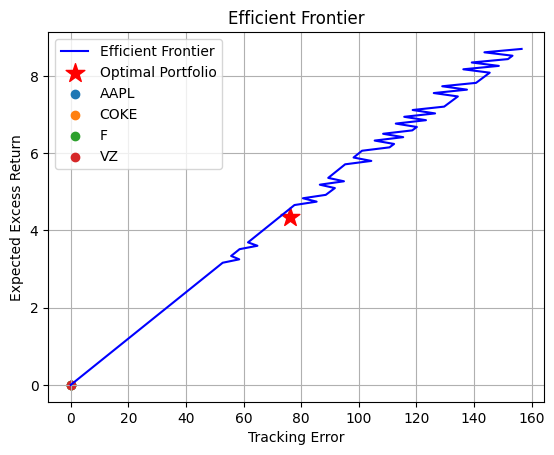

In [194]:
plt.plot(tracking_errors, xs_returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_te, opt_port_xs_return, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Tracking Error'].iloc[i], assets['Expected Return'].iloc[i], label=ticker)

plt.xlabel('Tracking Error')
plt.ylabel('Expected Excess Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

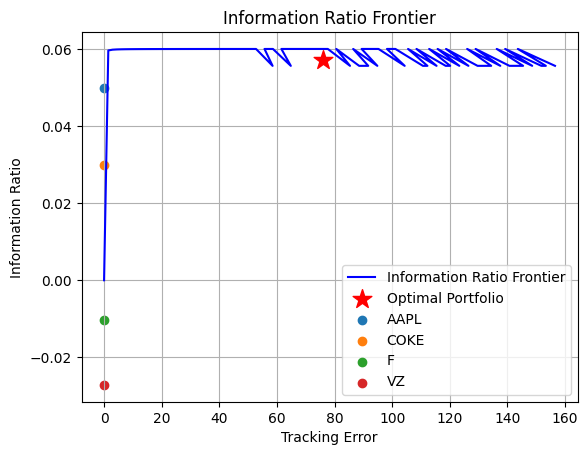

In [195]:
# Sharpe Graph
plt.plot(portfolios['Tracking Error'], portfolios['Information Ratio'], 'b-', label='Information Ratio Frontier')
plt.scatter(opt_port_te, opt_port_ir, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Tracking Error'].iloc[i], assets['Information Ratio'].iloc[i], label=ticker)

    
plt.xlabel('Tracking Error')
plt.ylabel('Information Ratio')
plt.title('Information Ratio Frontier')
plt.legend()
plt.grid(True)
plt.show()